# 1. 导入所需要的库

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn.preprocessing as preprocessing
import sklearn.cluster as cluster

### 导入数据, 对数据进行基本的观察

In [3]:
buyer = pd.read_excel(r'../work_hw/buyers.xlsx')
order = pd.read_excel(r'../work_hw/order.xlsx')


In [4]:
buyer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   买方代码    677 non-null    object 
 1   订单序号    651 non-null    float64
 2   收货人姓名   677 non-null    object 
 3   客户姓名    677 non-null    object 
 4   客户性别    677 non-null    object 
 5   客户年龄    677 non-null    int64  
 6   客户职业    677 non-null    object 
 7   客户国家    677 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 42.4+ KB


In [5]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   订单编号        651 non-null    float64
 1   订单金额（美元）    674 non-null    float64
 2   下单时间        677 non-null    object 
 3   支付时间        677 non-null    object 
 4   海关申报价值      677 non-null    int64  
 5   预计重量（KG）    677 non-null    float64
 6   海关申报重量（KG）  677 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 37.1+ KB


In [6]:
buyer.describe()

,订单序号,客户年龄
count,6.510000e+02,677.000000
mean,3.898618e+14,38.183161
std,2.923020e+14,9.919147
min,3.088386e+13,20.000000
25%,9.389964e+13,31.000000
50%,5.062334e+14,36.000000
75%,7.022501e+14,42.000000
max,7.029787e+14,79.000000


In [7]:
order.describe()

,订单编号,订单金额（美元）,海关申报价值,预计重量（KG）,海关申报重量（KG）
count,6.510000e+02,674.000000,677.000000,677.000000,677.000000
mean,3.898618e+14,39.797671,2.205318,0.129258,0.191356
std,2.923020e+14,71.261967,0.668900,0.200632,0.042070
min,3.088386e+13,0.000000,0.000000,0.000000,0.000000
25%,9.389964e+13,8.600000,2.000000,0.000000,0.200000
50%,5.062334e+14,15.395000,2.000000,0.000000,0.200000
75%,7.022501e+14,58.490000,3.000000,0.200000,0.200000
max,7.029787e+14,1245.660000,5.000000,2.200000,0.380000


## 进行数据缺失值的查找

In [8]:
order_missing = order.isnull().sum() / len(order) * 100
order_missing

订单编号          3.840473
订单金额（美元）      0.443131
下单时间          0.000000
支付时间          0.000000
海关申报价值        0.000000
预计重量（KG）      0.000000
海关申报重量（KG）    0.000000
dtype: float64

In [9]:
buyer_missing = buyer.isnull().sum() / len(buyer) * 100
buyer_missing

买方代码     0.000000
订单序号     3.840473
收货人姓名    0.000000
客户姓名     0.000000
客户性别     0.000000
客户年龄     0.000000
客户职业     0.000000
客户国家     0.000000
dtype: float64

In [10]:
order = order.dropna(subset=["订单编号"])
buyer = buyer.dropna(subset=["订单序号"])

In [11]:
order_money_mode = order['订单金额（美元）'].mode()[0]
order_money_mode

np.float64(8.6)

### 使用众数填充缺失值

In [12]:
order['订单金额（美元）'] = order['订单金额（美元）'].fillna(order_money_mode)

## 异常值处理

In [13]:
order.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651 entries, 0 to 676
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   订单编号        651 non-null    float64
 1   订单金额（美元）    651 non-null    float64
 2   下单时间        651 non-null    object 
 3   支付时间        651 non-null    object 
 4   海关申报价值      651 non-null    int64  
 5   预计重量（KG）    651 non-null    float64
 6   海关申报重量（KG）  651 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 40.7+ KB


In [14]:
# 计算四分位的上下界
def quartile_range(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# 调用时：
order_lower_bound, order_upper_bound = quartile_range(order['订单金额（美元）']) #计算边界值
print(f"订单金额（美元）的异常值范围: 下界 = {order_lower_bound}, 上界 = {order_upper_bound}")

订单金额（美元）的异常值范围: 下界 = -64.66, 上界 = 130.7


In [15]:
order['订单金额（美元）_change'] = np.clip(order["订单金额（美元）"], a_min=order_lower_bound, a_max=order_upper_bound) # 将异常值替换为边界值

# FRM模型

### 需要合并两张表

In [16]:
dataframe = order.merge(buyer, left_on='订单编号', right_on='订单序号', how='inner')
df_missing = dataframe.isnull().sum() / len(dataframe) * 100
df_missing

订单编号               0.0
订单金额（美元）           0.0
下单时间               0.0
支付时间               0.0
海关申报价值             0.0
预计重量（KG）           0.0
海关申报重量（KG）         0.0
订单金额（美元）_change    0.0
买方代码               0.0
订单序号               0.0
收货人姓名              0.0
客户姓名               0.0
客户性别               0.0
客户年龄               0.0
客户职业               0.0
客户国家               0.0
dtype: float64

In [17]:
dataframe

,订单编号,订单金额（美元）,下单时间,支付时间,海关申报价值,预计重量（KG）,海关申报重量（KG）,订单金额（美元）_change,买方代码,订单序号,收货人姓名,客户姓名,客户性别,客户年龄,客户职业,客户国家
0,7.021890e+14,74.51,2018-07-20 18:36:08.0,2018-07-21 21:41:49.0,2,0.0,0.2,74.51,ru1112407651afqw,7.021890e+14,Ermolaeva Polina Viktorovna,Polina Ermolaeva,male,30,Financial_Analyst,俄罗斯
1,9.358370e+13,9.00,2018-08-05 00:07:19.0,2018-08-05 00:07:22.0,2,0.2,0.2,9.00,us1231363659kxvb,9.358370e+13,Vitalij Samar,VITALII SAMAR,female,42,Surveyor,美国
2,7.022481e+14,11.00,2018-07-31 05:41:20.0,2018-07-31 05:41:22.0,2,0.2,0.2,11.00,ru1121390141beji,7.022481e+14,Fedorova Natalya Vasil'evna,Natalia Fedorova,female,32,Politician,俄罗斯
3,3.090601e+13,70.00,2018-07-20 00:25:45.0,2018-07-20 00:26:52.0,2,0.0,0.2,70.00,th1517970020igzd,3.090601e+13,Thicomporn chaiiam,thicomporn lohsiri,female,33,Technical_writer,泰国
4,7.021443e+14,8.40,2018-07-15 18:19:00.0,2018-07-15 18:19:53.0,3,0.2,0.2,8.40,ru1142801564eafg,7.021443e+14,Viktoria Pikhanova,Viktoria Pihanova,male,36,Scientist,俄罗斯
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,9.500422e+13,15.29,2018-10-01 12:11:10.0,2018-10-01 12:11:12.0,2,0.2,0.2,15.29,fi79045086goxae,9.500422e+13,natalja dmitrijeva,nataldam n,female,42,Hotel_Manager,芬兰
647,7.021847e+14,8.60,2018-07-21 19:07:35.0,2018-07-21 19:07:43.0,2,0.2,0.2,8.60,ru1080479545,7.021847e+14,Arustamova Yulia Evgenievna,Konstantin Arustamov,female,44,Psychologist,俄罗斯
648,9.260165e+13,113.14,2018-06-23 06:07:35.0,2018-06-23 06:07:39.0,3,0.0,0.2,113.14,il1280638814piui,9.260165e+13,bader khoury,bader khoury,female,46,Mechanical_engineer,以色列
649,9.369057e+13,3.98,2018-08-14 18:44:55.0,2018-08-14 18:46:18.0,2,0.0,0.2,3.98,ua1187326356sfnr,9.369057e+13,Margarita Dzhim,Margarita Dzhim,male,31,Microbiologist,乌克兰


In [18]:
#按照要求建立一张新的表
RFM = pd.DataFrame()

# 确保 '下单时间' 列为 datetime 类型
dataframe['下单时间'] = pd.to_datetime(dataframe['下单时间'])

# 计算每个客户的最近下单时间
last_order = dataframe.groupby('客户姓名')['下单时间'].max()

# 计算到2019年1月1日的天数（Recency），并赋值到 RFM 表中
RFM['Recency'] = (datetime.datetime(year=2019, month=1, day=1) - last_order).dt.days

# 计算购买频率(Frequency)
RFM["Frequency"] = dataframe.groupby('客户姓名')['订单编号'].count()

# 计算购买金额(Monetary)
RFM['Monetary'] = dataframe.groupby('客户姓名')['订单金额（美元）_change'].sum()

RFM


,Recency,Frequency,Monetary
客户姓名,,,
ALEX ALEX,151,1,7.60
ANASTASIYA Sukhareva,189,1,8.60
Agueda Ramón,126,1,10.76
Ahuir Audrey,84,1,15.14
Aigul Ishankulova,98,1,111.67
...,...,...,...
yulia konev,125,1,7.64
yulies farrel,179,1,64.63
yworl NA,198,1,32.46


# 数据聚类

In [19]:
RFM_df = pd.DataFrame()
RFM_df['M_log'] = np.log1p(RFM['Monetary'] + 1)
RFM_df['F_log'] = np.log1p(RFM['Frequency'] + 1)
RFM_df['R_log'] = np.log1p(RFM['Recency'] + 1)

In [20]:
#归一化
scaler = preprocessing.MinMaxScaler()
RFM_normalized = scaler.fit_transform(RFM_df)


Text(0.5, 1.0, 'Elbow Method for Optimal k')

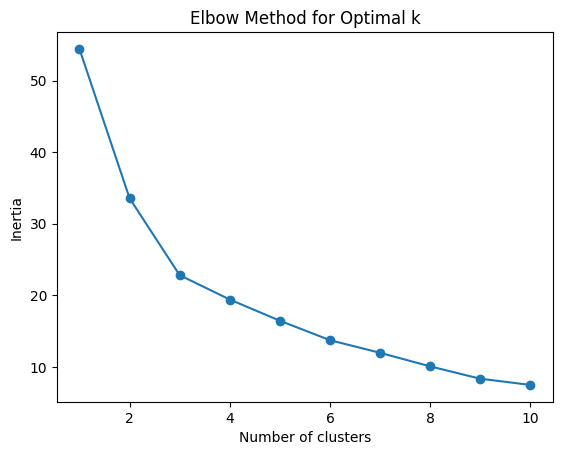

In [ ]:
inertia = []
#使用肘部法则确定最佳聚类数
for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=41)
    kmeans.fit(RFM_normalized)
    inertia.append(kmeans.inertia_)
# 绘制肘部图
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

In [24]:
# 最终确定聚类数为4
k = 4
kmeans = cluster.KMeans(n_clusters=k, random_state=41)
RFM_df['Cluster'] = kmeans.fit_predict(RFM_normalized)
RFM_df

,M_log,F_log,R_log,Cluster
客户姓名,,,,
ALEX ALEX,2.261763,1.098612,5.030438,0
ANASTASIYA Sukhareva,2.360854,1.098612,5.252273,3
Agueda Ramón,2.546315,1.098612,4.852030,0
Ahuir Audrey,2.841415,1.098612,4.454347,2
Aigul Ishankulova,4.733300,1.098612,4.605170,2
...,...,...,...,...
yulia konev,2.265921,1.098612,4.844187,0
yulies farrel,4.199155,1.098612,5.198497,1
yworl NA,3.539799,1.098612,5.298317,3


In [27]:
cluster_profile = RFM_df.groupby('Cluster')[['R_log', 'F_log', 'M_log']].mean()
print("----- 聚类群体画像 ---")
print(cluster_profile.sort_values(by='M_log', ascending=False))

----- 聚类群体画像 ---
            R_log     F_log     M_log
Cluster                              
1        5.099869  1.166125  4.328167
2        4.424097  1.188927  3.768462
3        5.201110  1.104198  2.518314
0        4.890373  1.109468  2.287020
